In [12]:
import random
import matplotlib.pyplot as plt #comment this out for autograder
import matplotlib.ticker as ticker #comment this out for autograder
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [13]:
class Bidder1:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.round_number = 1
        self.approx_train_rounds_per_user = round((self.num_rounds/ self.num_users)/3,0) # take 1/3 of total rounds per for training
        
        
        self.bidder_budget = 0
        self.usr_clickrate_dict = {}
        self.user_aggregate_winrate_dict = {}
        self.user_aggregate_click_dict = {}
        self.final_bid = 0
        self.log = np.array([]) 
        self.personal_bid_pattern = np.array([[self.round_number, None, None, None, self.bidder_budget]])

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    # EV Calculator (Based on Last 10 bets)
    def ev(self, second_price_bid, est_win_rate, est_click_rate):
        """return the expected value of a bid, given the click rate probability of a user X"""
        return (est_click_rate * (1 - second_price_bid) )+ ((1-est_click_rate) * (0 - second_price_bid) ) 

    def bid_price(self, ev, click_rate):
        """return the bid price of a given expected value, relative to the est. click rate"""
        return (click_rate - ev)

    def calculate_ev_lastNbids(self, num_bid_lookback, user_id, user_log, est_win_rate, est_click_rate):
        """calculate the EV w.r.t the last 10 winning bids on a given user"""
        # Filter for user_id (not string object)
        user_log = user_log[user_log[:, 0] == user_id]
        # Find the mean for user ID, based on last N bids
        count_last_N_bids = 0-num_bid_lookback
        mean = user_log[:,2][count_last_N_bids:].mean()
        # Use objective function to return the final EV of last 10 bids mean
        return mean, self.ev(mean, est_win_rate, est_click_rate)

    def submit_ev_bid_price(self, user_id, est_win_rate, est_click_rate, log):
        """Submite a bid price based on the Expected Value (EV) Margins between the estimated click rate ev and the last 5 2nd Price EVs"""
        last10, last10ev =  self.calculate_ev_lastNbids(10, user_id, log, est_win_rate, est_click_rate)
        last3, last3ev =  self.calculate_ev_lastNbids(3, user_id, log, est_win_rate, est_click_rate)
        
        if last10ev < 0:
            self.final_bid = 0.0001
        
        # else:
        #     self.final_bid = (last10+ 0.00001) * 5
        else:
            if last3ev < 0:
                self.final_bid = 0.0001
            else:
                self.final_bid = (last10+ 0.00001) * 5
        
        return self.final_bid
    
    def update_dict(self,user, final_bid, bidder_log):
        """Use the bidder log to update the click rate dictionary"""
        if final_bid == None:
            return
        
        user_log = bidder_log[bidder_log[:, 0] == user]
        if len(user_log) == 0:
            return 0
        
        last_record = user_log[-1]
        _, user_won, _, user_clicked = last_record

        self.usr_clickrate_dict[user]["total_rounds"] += 1
        if user_won:
            self.usr_clickrate_dict[user]["total_wins"] += 1
        if user_clicked:
            self.usr_clickrate_dict[user]["total_clicks"] += 1

        bid_modifier = 1 if user_clicked else 0
        self.bidder_budget += (bid_modifier - final_bid)
    
        if self.usr_clickrate_dict[user]["total_wins"] > 0:
            self.user_aggregate_click_dict[user] = self.usr_clickrate_dict[user]["total_clicks"] / self.usr_clickrate_dict[user]["total_wins"]
            self.user_aggregate_winrate_dict[user] = self.usr_clickrate_dict[user]["total_wins"] / self.usr_clickrate_dict[user]["total_rounds"]
        else:
            self.user_aggregate_click_dict[user] = 0
            self.user_aggregate_winrate_dict[user] = 0
    

    def aggressive_bid(self,user_id, bidder_log):
        """Aggressive Bidding Model. Objective is to bid high to attain the click rate data early on."""
        
        if self.approx_train_rounds_per_user >= 10:
            # Check if the user is not already in the dictionary
            if user_id not in self.usr_clickrate_dict : #and self.bidder_budget >= -12:
                # If the user is not in the dictionary, add a new entry with a nested dictionary
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": 10,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.user_aggregate_click_dict[user_id] = 0
                self.user_aggregate_winrate_dict[user_id] = 0
                self.final_bid = 1
                return self.final_bid

            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0 : # and self.bidder_budget >= -12:
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                last_record = user_log[-1,:]
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                # take the most recent bid and final_bid would be double
                self.final_bid = max(last_record[2] * 2,1)
                return self.final_bid
            else:
                return 0

        else:
            # Check if the user is not already in the dictionary
            if user_id not in self.usr_clickrate_dict:
                # If the user is not in the dictionary, add a new entry with a nested dictionary
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": self.approx_train_rounds_per_user,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }

                self.final_bid = 1
                return self.final_bid

            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                
                # take the most recent bid and return double as final_bid
                self.final_bid = user_log[-1:,2] * 2
                return self.final_bid
            else:
                return 0

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id

        if self.user_id not in self.usr_clickrate_dict:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid
        
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 0 and self.bidder_budget >= -20:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid

        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 7:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid
        else:
            est_win_rate = self.user_aggregate_winrate_dict[self.user_id]
            est_click_rate = self.user_aggregate_click_dict[self.user_id]
            self.final_bid = self.submit_ev_bid_price(self.user_id, est_win_rate, est_click_rate, self.log)
            #final_bid = random.uniform(0,1)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'ev_bid', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.submit_ev_bid_price(self.user_id, est_win_rate, est_click_rate, self.log)


    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = np.array([new_entry])
            self.update_dict(self.user_id, self.final_bid, self.log)
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
            self.update_dict(self.user_id, self.final_bid, self.log)
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [14]:
import numpy as np

class Bidder2:
    """Bidder Class for the Auction"""
    _instance_count = 1

    def __init__(self, num_users, num_rounds):
        self.bidder_id = Bidder._instance_count
        Bidder._instance_count += 1
        self.num_users = num_users
        self.num_rounds = num_rounds
        self.round_number = 1
        self.approx_train_rounds_per_user = round((self.num_rounds / self.num_users) / 3, 0)
        self.bidder_budget = 0
        self.usr_clickrate_dict = {}
        self.user_aggregate_click_dict = {}
        self.final_bid = 0
        self.log = np.array([])
        self.personal_bid_pattern = np.array([[self.round_number, None, None, None, self.bidder_budget]])

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def calculate_expected_value(self, second_price_bid, est_click_rate):
        """Return expected value of a bid given the click rate."""
        return est_click_rate * (1 - second_price_bid) + (1 - est_click_rate) * (0 - second_price_bid)

    def bid_price(self, expected_val, click_rate):
        """Return bid price of a given expected value """
        return click_rate - expected_val

    def calculate_expected_val_last_n_bids(self, num_bid_lookback, user_id, user_log, est_click_rate):
        """Calculate the expected_val with respect to the last N winning bids on a given user."""
        user_log = user_log[user_log[:, 0] == user_id]
        count_last_n_bids = 0 - num_bid_lookback
        mean = user_log[:, 2][count_last_n_bids:].mean()
        return mean, self.calculate_expected_value(mean, est_click_rate)

    def submit_expected_val_bid_price(self, user_id, est_click_rate, log):
        """Submit a bid price based on the expected_val"""
        last10, last10_expected_val = self.calculate_expected_val_last_n_bids(10, user_id, log, est_click_rate)
        _, last3_expected_val = self.calculate_expected_val_last_n_bids(3, user_id, log, est_click_rate)

        if last10_expected_val < 0:
            self.final_bid = 0.0001
        else:
            if last3_expected_val < 0:
                self.final_bid = 0.0001
            else:
                self.final_bid = (last10 + 0.00001) * 5

        return self.final_bid

    def update_dict(self, user, final_bid, bidder_log):
        """Use the bidder log to update the click rate dictionary."""
        if final_bid is None:
            return 0

        user_log = bidder_log[bidder_log[:, 0] == user]
        if len(user_log) == 0:
            return 0

        last_record = user_log[-1]
        _, user_won, _, user_clicked = last_record

        self.usr_clickrate_dict[user]["total_rounds"] += 1
        if user_won:
            self.usr_clickrate_dict[user]["total_wins"] += 1
        if user_clicked:
            self.usr_clickrate_dict[user]["total_clicks"] += 1

        bid_modifier = 1 if user_clicked else 0
        self.bidder_budget += (bid_modifier - final_bid)

        if self.usr_clickrate_dict[user]["total_wins"] > 0:
            self.user_aggregate_click_dict[user] = self.usr_clickrate_dict[user]["total_clicks"] / self.usr_clickrate_dict[user]["total_wins"]
        else:
            self.user_aggregate_click_dict[user] = 0

    def aggressive_bid(self, user_id, bidder_log):
        """Use aggressive bidding method"""
        if self.approx_train_rounds_per_user >= 10:
            if user_id not in self.usr_clickrate_dict:
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": 10,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.user_aggregate_click_dict[user_id] = 0
                self.final_bid = 1
            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                last_record = user_log[-1, :]
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                self.final_bid = max(last_record[2] * 2, 1)
            else:
                self.final_bid = 0
        else:
            if user_id not in self.usr_clickrate_dict:
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": self.approx_train_rounds_per_user,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.final_bid = 1
            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                self.final_bid = user_log[-1:, 2] * 2
                return self.final_bid
            else:
                self.final_bid = 0
        return self.final_bid

    def bid(self, user_id):
        """Return Bid to auction."""
        self.user_id = user_id

        if self.user_id not in self.usr_clickrate_dict:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 0 and self.bidder_budget >= -20:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 7:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        else:
            est_click_rate = self.user_aggregate_click_dict[self.user_id]
            self.final_bid = self.submit_expected_val_bid_price(self.user_id, est_click_rate, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'expected_val_bid', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        
        return self.final_bid

    def notify(self, auction_winner, price, clicked):
        """Append auction details to internal log."""
        self.auction_winner = auction_winner
        self.price = price
        self.clicked = clicked
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])

        if self.log.size == 0:
            self.log = np.array([new_entry])
            self.update_dict(self.user_id, self.final_bid, self.log)
        else:
            self.log = np.vstack((self.log, new_entry))
            self.update_dict(self.user_id, self.final_bid, self.log)


In [15]:
class Bidder3:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.uniform(-.01,0.25)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [16]:
class Bidder4:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.gauss(0.5,1)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [17]:
class Bidder5:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.gauss(0.45, 1)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

Balances after 1000 rounds:
{b1: 0, b2: -83.80602329511058, b3: -105.85532377089469, b4: 50.577087006979475, b5: 6.81463431361038, b6: 4.982687018176175}

Balances history after 10 rounds:
Bidder: b1, Round: 1, Bid: 0, Users: u1, User_Clicked: False, Balance: 0
Bidder: b2, Round: 1, Bid: 1, Users: u1, User_Clicked: False, Balance: 0
Bidder: b3, Round: 1, Bid: 1, Users: u1, User_Clicked: False, Balance: -1
Bidder: b4, Round: 1, Bid: 0.091, Users: u1, User_Clicked: False, Balance: 0
Bidder: b5, Round: 1, Bid: 0.563, Users: u1, User_Clicked: False, Balance: 0
Bidder: b6, Round: 1, Bid: 0, Users: u1, User_Clicked: False, Balance: 0
Bidder: b1, Round: 2, Bid: 0, Users: u3, User_Clicked: False, Balance: 0
Bidder: b2, Round: 2, Bid: 1, Users: u3, User_Clicked: False, Balance: 0
Bidder: b3, Round: 2, Bid: 1, Users: u3, User_Clicked: False, Balance: -2
Bidder: b4, Round: 2, Bid: 0.235, Users: u3, User_Clicked: False, Balance: 0
Bidder: b5, Round: 2, Bid: 0.416, Users: u3, User_Clicked: False, B

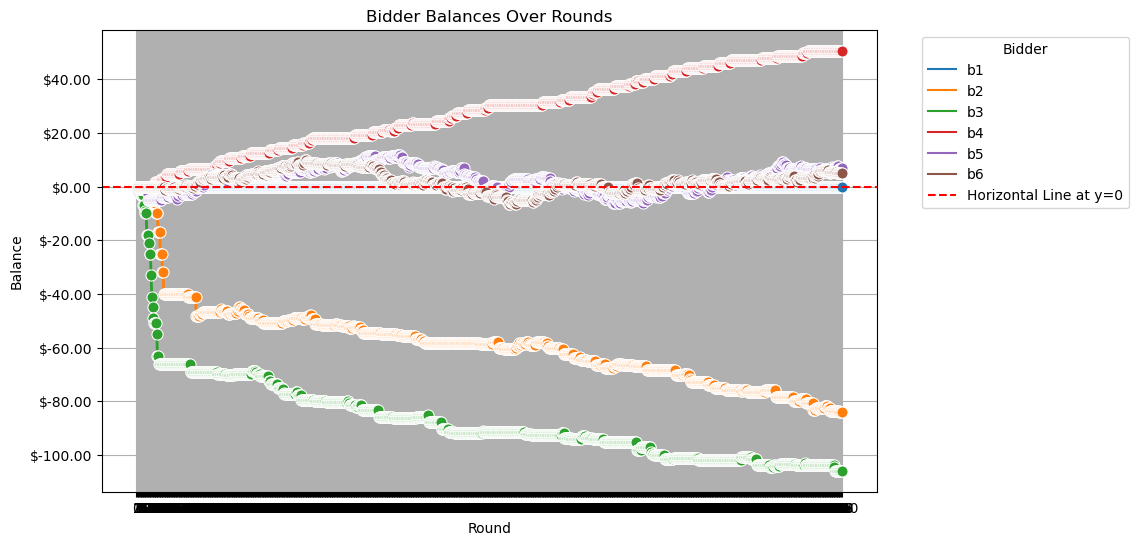

In [18]:
# Design the following classes

import random
import numpy as np

class User:
    """User Class for the Auction"""
    _instance_count = 0
    def __init__(self):
        self.__probability = random.uniform(0,1)
        self.user_id = User._instance_count
        User._instance_count += 1

    def __repr__(self):
        return f"u{self.user_id}"

    def __str__(self):
        return f"u{self.user_id}"
    
    def show_ad(self):
        """This method should return True to represent the user clicking on and ad and
            otherwise."""
        return True if np.random.rand() <= self.__probability else False


class Bidder:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        #final_bid = random.uniform(0.5,1.5)
        final_bid = 0
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

class Auction:
    
    def __init__(self, users, bidders):
        self.users = users
        self.bidders = bidders
        self.balances = {bidder: 0 for bidder in self.bidders}
        self.balances_history = []
        self.round_count = 1

    def __repr__(self):
        return f"Auction(users={self.users}, bidders={self.bidders})"

    def __str__(self):
        return f"Auction with {len(self.users)} users and {len(self.bidders)} bidders"

    def execute_round(self):
        """Execute all steps within a single round of the game."""
        user_id = random.choice(self.users)
        bids = {}

        for bidder in self.bidders:
            final_bid = bidder.bid(user_id)
            bids[bidder] = max(0, final_bid)

        highest_bid = max((bid for bid in bids.values() if bid is not None), default=None)
        tie_bidders = [bidder for bidder, bid in bids.items() if bid == highest_bid]

        if len(tie_bidders) >= 2:
            winner = random.choice(tie_bidders)
            tie_bidders.remove(winner)
            second_highest_bid = bids[random.choice(tie_bidders)]
        else:
            winner = tie_bidders[0]
            second_highest_bid = float('-inf')

        for bidder, bid in bids.items():
            if bid is not None and bid > second_highest_bid and bidder != winner:
                second_highest_bid = bid

        clicked = user_id.show_ad()

        for bidder in self.bidders:
            if bidder == winner:
                bidder.notify(auction_winner=True, price=second_highest_bid, clicked=clicked)
                if clicked:
                    self.balances[winner] += (1 - second_highest_bid)
                else:
                    self.balances[winner] -= second_highest_bid
            else:
                bidder.notify(auction_winner=False, price=second_highest_bid, clicked=None)
                self.balances[bidder] -= 0

        for bidder in self.bidders:
            self.balances_history.append((bidder, self.round_count, bids[bidder], user_id, clicked, self.balances[bidder]))
        self.round_count += 1
        
    def plot_history(self):
        """Creates a visual representation of how the auction has proceeded using Seaborn."""
        plt.figure(figsize=(10, 6))

        # Extract data for Seaborn plot
        bidder_ids = []
        rounds = []
        bids = []
        users = []
        clicked_values = []
        balances = []
        for bidder, round_num, bid, chosen_user_id, clicked, balance in self.balances_history:
            bidder_ids.append(str(bidder))
            rounds.append(round_num)
            bids.append(bid)
            users.append(chosen_user_id)
            clicked_values.append(clicked)
            balances.append(balance)

        # Create a Seaborn line plot
        data = {'Bidder': bidder_ids, 'Round': rounds, 'Bid': bids, 'Chosen User': users, 'Clicked': clicked_values, 'Balance': balances}
        df = pd.DataFrame(data)
        sns.lineplot(data=df, x='Round', y='Balance', hue='Bidder', marker='o', markersize=8, linewidth=2)

        # Draw horizontal line at y=0
        plt.axhline(y=0, color='red', linestyle='--', label='Horizontal Line at y=0')

        plt.xlabel('Round')
        plt.ylabel('Balance')
        plt.title('Bidder Balances Over Rounds')
        plt.xticks(range(self.round_count))
        plt.legend(title='Bidder', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)

        # Format y-axis as currency (US dollars)
        currency_format = ticker.StrMethodFormatter('${x:,.2f}')
        plt.gca().yaxis.set_major_formatter(currency_format)
        plt.show()


if __name__ == "__main__":
    user_count = 9
    round_count = 1000
    b1, b2, b3, b4, b5, b10= Bidder(user_count,round_count), Bidder1(user_count,round_count), Bidder2(user_count,round_count), Bidder3(user_count,round_count), Bidder4(user_count,round_count), Bidder5(user_count,round_count)
    u0, u1, u2, u3, u4, u5, u6, u7, u8 = User(), User(), User(),User(), User(), User(),User(), User(), User()
    auction = Auction([u0, u1, u2, u3, u4, u5, u6, u7, u8],[b1, b2, b3, b4, b5, b10])
    
    # Run multiple rounds (for example, 10 rounds)
    for _ in range(round_count):
        auction.execute_round()

    # Print balances and balances_history after 10 rounds
    print(f"Balances after {round_count} rounds:")
    print(auction.balances)
    
    print("\nBalances history after 10 rounds:")
    for bidder, round_num, bid, users, clicked, balance in auction.balances_history:
        print(f"Bidder: {bidder}, Round: {round_num}, Bid: {round(bid,3)}, Users: {users}, User_Clicked: {clicked}, Balance: {round(balance,3)}")

    # Plot the auction history after 10 rounds using Seaborn
    auction.plot_history()